In [33]:
# Importing dependencies

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from pathlib import Path
import pandas as pd
from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from matrix_util import *
import tensorflow as tf

# Cleaning up the Dataset

In [34]:
# importing CSV file containing image labels and corresponding image file names

path_to_labels="data/legend.csv"

data=pd.read_csv(path_to_labels)


In [122]:
data

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral
5,302,Aaron_Guiel_0001.jpg,happiness
6,302,Aaron_Patterson_0001.jpg,neutral
7,302,Aaron_Peirsol_0001.jpg,happiness
8,302,Aaron_Peirsol_0002.jpg,happiness
9,302,Aaron_Peirsol_0003.jpg,happiness


In [36]:
# Lower casing all the values in the emotion column

data['emotion'] = [str(i).lower() for i in data["emotion"]]

In [37]:
# re-labelling all the columns labelled sad, with sadness for consistency

data['emotion']=data['emotion'].replace(to_replace='sadness', value='sad', regex=True)


In [38]:
labels=list(data['emotion'].unique())
labels

['anger',
 'surprise',
 'disgust',
 'fear',
 'neutral',
 'happiness',
 'sad',
 'contempt']

In [39]:
# Pick 4 emotions of choice i.e. anger, neutral, happiness, sad

restricted_to_specific_emo=data.loc[data.emotion.isin(["anger","neutral","happiness","sad"])].reset_index(drop=True)


In [40]:
# Labels we are going to use

using_labels=list(restricted_to_specific_emo['emotion'].unique())
using_labels

['anger', 'neutral', 'happiness', 'sad']

# USE OPEN CV2 to generate array for all images

In [41]:
import cv2


In [42]:
# Taking the column name "image" from the dataframe labelled data and converting to list

img_file_names = list(restricted_to_specific_emo["image"])


In [43]:
# To get the array value of each file

grayscale_image_array=[]

for i in range(len(img_file_names)):
    img_path = f"images/{img_file_names[i]}"
    img = cv2.imread(img_path,0)
    grayscale_image_array.append(img)
    

In [44]:
# Count the number of images for each image size

(
    pd.DataFrame.from_records(
        [img.shape for img in grayscale_image_array],
        columns=['num_rows', 'num_cols'])
    .groupby(['num_rows', 'num_cols'])
    .size()
    .rename('num_images')
    .to_frame()
    .sort_values(by="num_images", ascending=False)
).head()

,,num_images
num_rows,num_cols,
350,350,12823
37,27,3
91,73,3
99,80,2
73,58,2


In [45]:
# Taking the array values of all the images of size 350 by 350 and their corresponding emotion values and
# appending to new lists

grayscale_image_array_only_350by350=[]
emotions_only_350by350=[]


for i in range(len(grayscale_image_array)):
    img = grayscale_image_array[i]
    emotion = restricted_to_specific_emo.emotion[i]
    
    if img.shape == (350, 350):
        grayscale_image_array_only_350by350.append(img)
        emotions_only_350by350.append(emotion)

In [46]:
# Checking the size of the new lists

print(len(grayscale_image_array_only_350by350))
print(len(emotions_only_350by350))

12823
12823


In [47]:
# Changing the orientation of the image in multiple ways to create a more robust data set which will then be used 
# to train and test the model

images_reflected_horizontally=[]

images_reflected_vertically=[]

images_rotated_right=[]

images_rotated_left=[]

images_rotated_180=[]


for i in range(len(grayscale_image_array_only_350by350)):
    
    # grabs images and assigns to img
    img=grayscale_image_array_only_350by350[i]
    
    #reflects the image horizontally and appends to images_reflected_horizontally list
    images_reflected_horizontally.append(reflect_horizontally(img))
    
    #reflects the image vertically and appends to images_reflected_vertically list
    images_reflected_vertically.append(reflect_vertically(img))
    
    #rotates the image right and appends to images_rotated_right list
    images_rotated_right.append(rotate_right(img))
    
    #rotates the image left and appends to images_rotated_left list
    images_rotated_left.append(rotate_left(img))
    
    #rotates the image 180 degrees and appends to images_rotated_180 list
    images_rotated_180.append(rotate_180(img))
    

In [48]:
# this is my final list of images (X) in various orientations

final_list_images= (
    grayscale_image_array_only_350by350 + 
    images_reflected_horizontally + 
    images_reflected_vertically +
    images_rotated_right +
    images_rotated_left+
    images_rotated_180
    
)

In [49]:
# These are the emotion labels (y) corresponding to the X images

final_list_emotions= emotions_only_350by350*6


# This is done to get y and X 


In [50]:
# Converting list grayscale_image_array_only_350by350 to array and reshaping the dimensions

X = np.concatenate([
    img.reshape(1,350,350,1)
    for img in
    final_list_images
])

In [51]:
X.shape

(76938, 350, 350, 1)

In [52]:
# converting the text label into a number between 0 and 3 (because 4 labels) and converting this to 
# an array and reshaping

label_to_number_map = {
    label: idx for idx, label in enumerate(using_labels)}

emo_numbers = [
    label_to_number_map[emo] for emo in final_list_emotions
]
emo_numbers_array = np.array(emo_numbers).reshape(-1, 1)

In [53]:
# Converting the number into one hot encoding resulting in a matrix 

y = keras.utils.to_categorical(
    emo_numbers_array,
    len(using_labels))


In [54]:
# Creating a trained test split from the data

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)

In [82]:
model = Sequential()

model.add(Conv2D(2, (3, 3), padding='same', input_shape=(350,350,1), activation="relu"))
model.add(Conv2D(2, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(4, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(4, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(8, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(8, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(16, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(4, activation="softmax"))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print a summary of the model
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 350, 350, 2)       20        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 348, 348, 2)       38        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 174, 174, 2)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 174, 174, 2)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 174, 174, 4)       76        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 172, 172, 4)       148       
___________________________

In [207]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, mode='auto')

checkpointer = ModelCheckpoint('weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)



In [84]:
# Run the model fit on the training test using the test set for validation

history = model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=14,
          validation_data=(X_test,y_test),
          shuffle=True,
          callbacks=[lr_reducer, checkpointer, early_stopper]
)


Train on 57703 samples, validate on 19235 samples
Epoch 1/1
57703/57703 [==============================] - 3495s 61ms/step - loss: 0.8637 - acc: 0.5239 - val_loss: 0.8800 - val_acc: 0.5304

Epoch 00001: val_loss improved from inf to 0.88002, saving model to weights.hd5


In [86]:
print(history)

In [87]:
# This shows various accuracy and val loss for each epoch
history.history

{'val_loss': [0.8800231688946664],
 'val_acc': [0.5303873147922954],
 'loss': [0.8636690461063126],
 'acc': [0.5239069025879036],
 'lr': [0.001]}

In [88]:
model_structure = model.to_json()
f = Path("model_structure.json")
f.write_text(model_structure)

10169

In [89]:
# Save neural network's trained weights
model.save_weights("model_weights.h5")


In [205]:
from keras.models import model_from_json
from pathlib import Path
from keras.preprocessing import image
import numpy as np

# Load the json file that contains the model's structure
f = Path("model_structure.json")
model_structure = f.read_text()

# Recreate the Keras model object from the json data
model = model_from_json(model_structure)

# Re-load the model's trained weights
model.load_weights("model_weights.h5")

# Load an image file to test, resizing it to 350 X 350 pixels (as required by this model)
img = image.load_img("4.jpg", target_size=(350, 350),grayscale=True)

# Convert the image to a numpy array
image_to_test = image.img_to_array(img)


/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


This is image has a 78.51545810699463% likelihood of being happiness


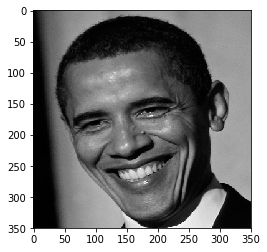

In [206]:
# Add a fourth dimension to the image (since Keras expects a list of images, not a single image)
list_of_images = np.expand_dims(image_to_test, axis=0)

# Make a prediction using the model
results = model.predict(list_of_images)

# Since we are only testing one image, we only need to check the first result
single_result = results[0]

# We will get a likelihood score for all 10 possible classes. Find out which class had the highest score.
most_likely_class_index = int(np.argmax(single_result))
class_likelihood = single_result[most_likely_class_index]

# Get the name of the most likely class
class_label = using_labels[most_likely_class_index]

# Print the result
print(f"This is image has a {class_likelihood*100}% likelihood of being {class_label}")
plt.imshow(img)


## Comments:
##### 1. Model is most consistently good at picking up Neutral and Happy facial expressions
##### 2. Anger and Sad expressions are not picked up as well. 
##### 3. Further investigation into the data set revealed that some of the images were not labelled as consistently as others especially for the anger and sadness facial expression
##### 4. 
##### 5.
##### 6.

In [ ]:
# If running an image from the test set you can check what the image is labelled as in the labelled data set

# data.loc[data['image'] =="Ahmed_Chalabi_0002.jpg" , 'emotion']

In [ ]:
# add timestamp to code to see when each epoch finishes
# mess the parameters and scle the model, prune it down and make a loop that runs several different model!!
# scale down the model take a look at params and do a quarter 